### Import Libraries

In [ ]:
!pip install pmdarima

In [1]:
# Pre Processing 
import pandas as pd
import datetime as dt
import numpy as np

# Exploratory Data
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import squarify 
%matplotlib inline

# Modeling 
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import pmdarima as pm
from fbprophet import Prophet

### Load Dataset

In [2]:
dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors = 'coerce')
Ecommerce = pd.read_csv('Ecommerce_Cleaned.csv',parse_dates=['Order Date','Ship Date'],date_parser=dateparse, low_memory=False)
pd.set_option('display.max_columns', None)
Ecommerce = Ecommerce.sort_values(by=['Order Date','Ship Date'],ascending=True)
Ecommerce.head(6)

,Order Date,Ship Date,Aging,Ship Mode,Product Category,Product,Quantity,Discount,Order Priority,Customer Name,Segment,City,State,Country,Region,Sales USD,Profit USD,Shipping Cost USD,Order Days of Week,Order Months,Order Weektype,Order Year Quarter
7738,2015-01-01,2015-01-01,1.0,Same Day,Electronic,Apple Laptop,5,0.04,Medium,Montgomery Dowd,Consumer,Bordeaux,Aquitaine,France,Central,250.0,120.0,12.0,Thursday,January,Weekday,1st Quarter
7916,2015-01-01,2015-01-01,1.0,Same Day,Electronic,Mouse,2,0.03,Medium,Ross Braxton,Consumer,Yicheng,Hubei,China,North Asia,111.0,24.0,2.4,Thursday,January,Weekday,1st Quarter
8012,2015-01-01,2015-01-01,1.0,Same Day,Electronic,Mouse,2,0.04,Medium,Bond Overcash,Consumer,Wheeling,West Virginia,United States,East,111.0,22.0,2.2,Thursday,January,Weekday,1st Quarter
9016,2015-01-01,2015-01-01,1.0,Same Day,Electronic,Watch,3,0.05,High,Sparks Mackendrick,Home Office,Açu,Rio Grande do Norte,Brazil,South,104.0,8.4,0.8,Thursday,January,Weekday,1st Quarter
9056,2015-01-01,2015-01-01,1.0,Same Day,Electronic,Tablet,4,0.05,High,Park Macintyre,Consumer,Turgutlu,Manisa,Turkey,EMEA,199.0,79.0,7.9,Thursday,January,Weekday,1st Quarter
9099,2015-01-01,2015-01-01,1.0,Same Day,Electronic,LED,4,0.05,Medium,Ortiz Carroll,Home Office,Kherson,Kherson,Ukraine,EMEA,192.0,73.0,7.4,Thursday,January,Weekday,1st Quarter


### Dataset Profiling

In [3]:
print("Dataset dimension :", Ecommerce.ndim)
print("Dataset shape :", Ecommerce.shape)
print("Dataset size :", Ecommerce.size)

Dataset dimension : 2
Dataset shape : (51288, 22)
Dataset size : 1128336


In [4]:
Ecommerce_types = Ecommerce.dtypes.reset_index()
Ecommerce_types.columns = ['Features','Data Types']
Ecommerce_types

,Features,Data Types
0,Order Date,datetime64[ns]
1,Ship Date,datetime64[ns]
2,Aging,float64
3,Ship Mode,object
4,Product Category,object
5,Product,object
6,Quantity,int64
7,Discount,float64
8,Order Priority,object
9,Customer Name,object


### Dataset Inspection

### Checking for Missing Value

In [5]:
missing_data = Ecommerce.isnull().sum().reset_index()
missing_data.columns = ['Features','Missing Values']
blank_data = Ecommerce.apply(lambda x: x == ' ').sum().reset_index()
blank_data.columns = ['Features','Blank Values']
merged_data = pd.merge(missing_data,blank_data, on=['Features'])
merged_data['Filling Factor'] = (Ecommerce.shape[0]-missing_data['Missing Values'] + Ecommerce.shape[0]-blank_data['Blank Values'])/Ecommerce.shape[0]*50
merged_data.sort_values(by='Filling Factor',ascending=True)

,Features,Missing Values,Blank Values,Filling Factor
0,Order Date,0,0,100.0
19,Order Months,0,0,100.0
18,Order Days of Week,0,0,100.0
17,Shipping Cost USD,0,0,100.0
16,Profit USD,0,0,100.0
15,Sales USD,0,0,100.0
14,Region,0,0,100.0
13,Country,0,0,100.0
12,State,0,0,100.0
11,City,0,0,100.0


### Cross Checking Missing Values with ASSERT Statement

In [6]:
# Assert that there are no missing values in the dataframe

assert pd.notnull(Ecommerce).all().all()

Interpretation
 - The above command does not throw any error. Hence, it is confirmed that there are no missing or negative values in the dataset.
 - All the values are greater than or equal to zero excluding character values.

### Dataset Overview

In [7]:
def initial_eda(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))
        
initial_eda(Ecommerce)

Dimensions : 51288 rows, 22 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                            Order Date datetime64[ns]          365          0
                             Ship Date datetime64[ns]          375          0
                                 Aging    float64           10          0
                             Ship Mode     object            5          0
                      Product Category     object            4          0
                               Product     object           42          0
                              Quantity      int64            5          0
                              Discount    float64            5          0
                        Order Priority     object            4          0
                         Customer Name     object          795          0
                               Segment     object            3          0
                                  City     ob

### Dataset Date Range

In [8]:
print("Dataset Minimum date value : {}".format(Ecommerce['Order Date'].min()))
print("Dataset Maximum date value : {}".format(Ecommerce['Order Date'].max()))

Dataset Minimum date value : 2015-01-01 00:00:00
Dataset Maximum date value : 2015-12-31 00:00:00


### Time Series Exploratory Data

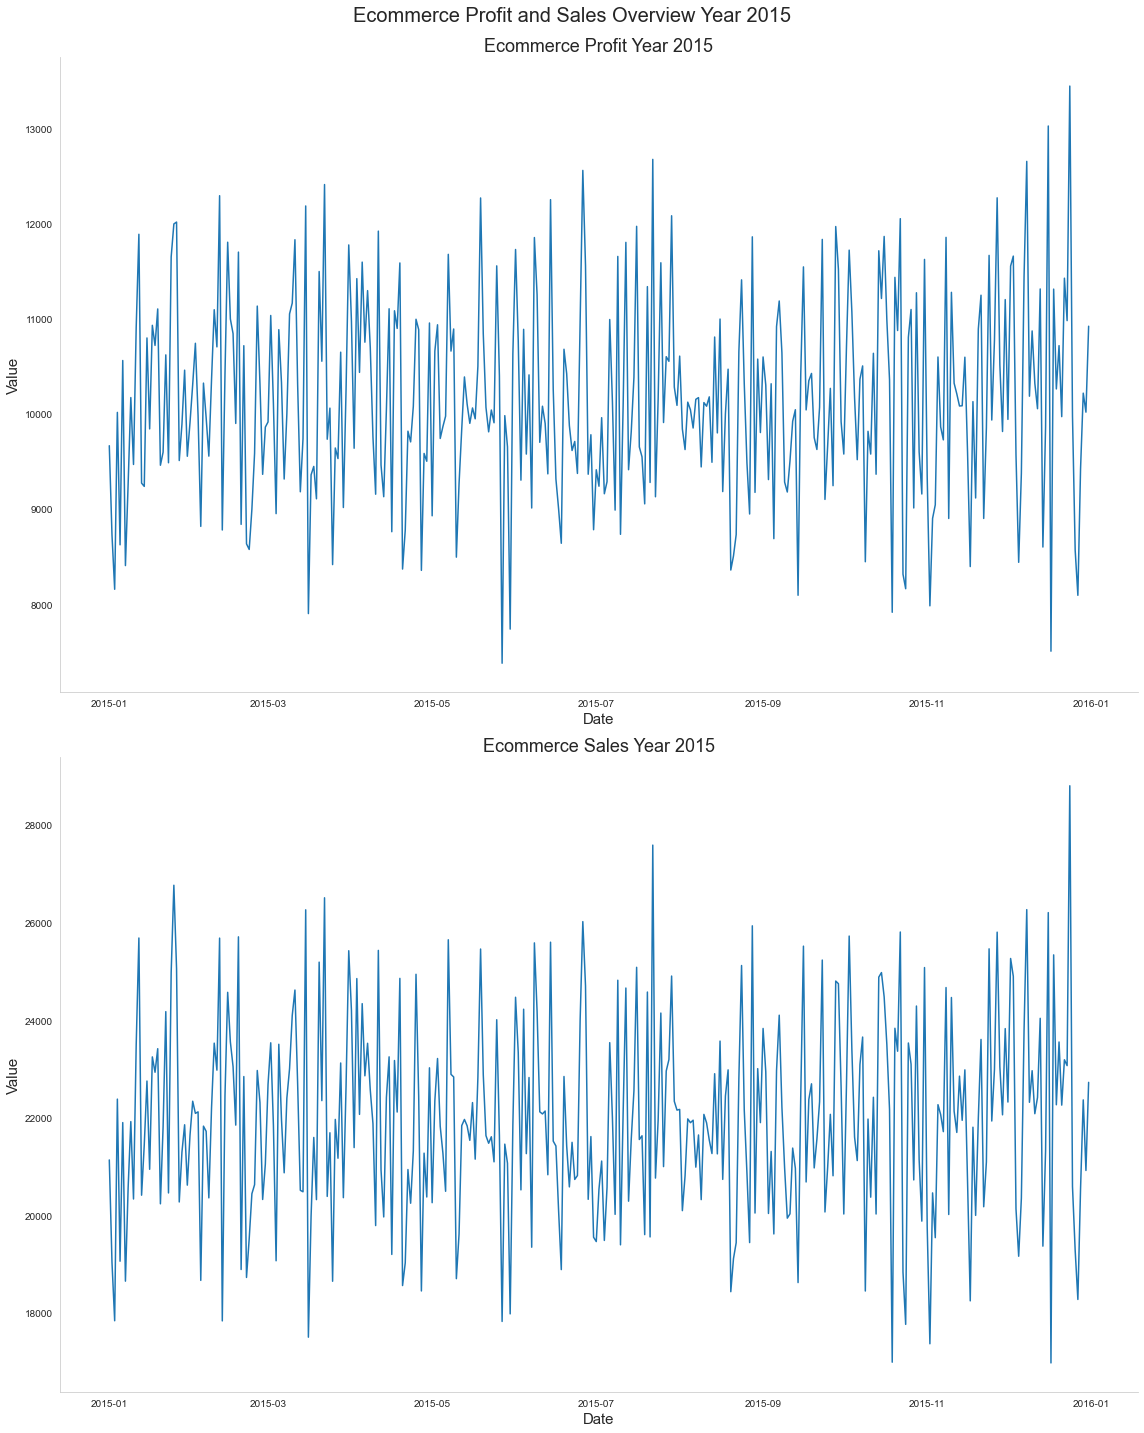

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(16,20))
fig.suptitle("Ecommerce Profit and Sales Overview Year 2015", fontsize=20, verticalalignment="bottom")
 
#Plot 1
colors1 = ['#FF9A00','#242F41']
ODpro = pd.DataFrame(Ecommerce.groupby('Order Date', as_index=False)['Profit USD'].sum())
ax1=sns.lineplot(data=ODpro, x='Order Date',y='Profit USD',ax=ax1)
ax1.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax1.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Ecommerce Profit Year 2015',fontsize=18, fontweight='normal')

#Plot 2
ODsale = pd.DataFrame(Ecommerce.groupby('Order Date', as_index=False)['Sales USD'].sum())
ax2=sns.lineplot(data=ODsale, x='Order Date',y='Sales USD',ax=ax2)
ax2.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax2.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Ecommerce Sales Year 2015',fontsize=18, fontweight='normal')

plt.tight_layout()

### Time Series Stationary Checking

### Profit

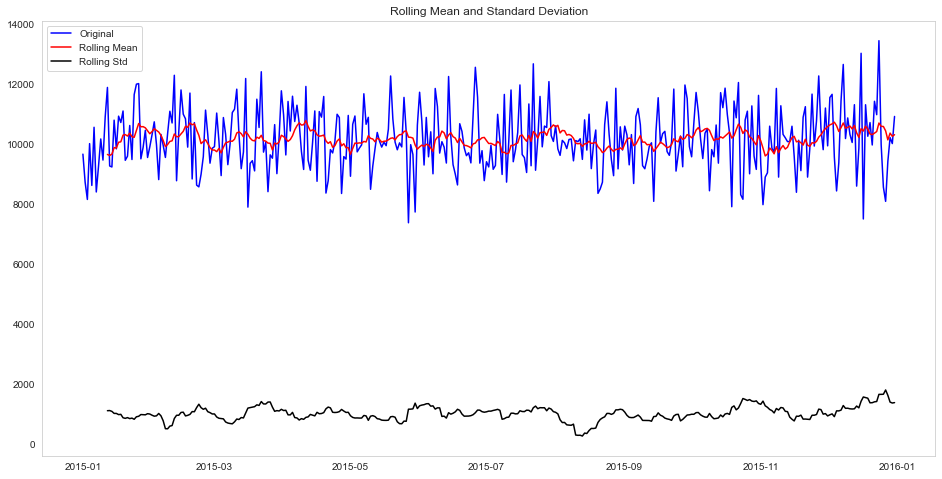

Results of dickey fuller test
Test Statistics               -1.864043e+01
p-value                        2.054278e-30
No. of lags used               0.000000e+00
Number of observations used    3.640000e+02
critical value (1%)           -3.448443e+00
critical value (5%)           -2.869513e+00
critical value (10%)          -2.571018e+00
dtype: float64


In [15]:
# Setting Date as Index
ODpro_date_index = ODpro.set_index('Order Date')

# Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(ODpro_date_index['Profit USD'])

### Sales

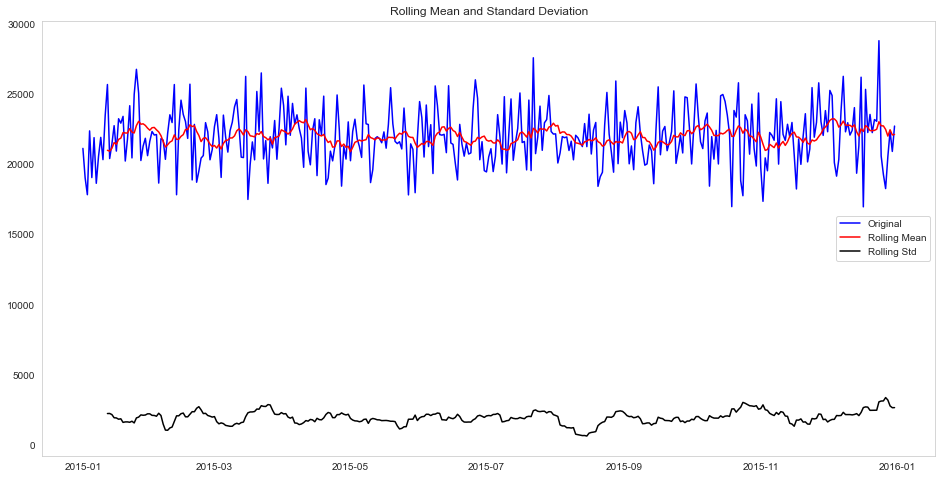

Results of dickey fuller test
Test Statistics                -18.936836
p-value                          0.000000
No. of lags used                 0.000000
Number of observations used    364.000000
critical value (1%)             -3.448443
critical value (5%)             -2.869513
critical value (10%)            -2.571018
dtype: float64


In [16]:
# Setting Date as Index
ODsale_date_index = ODsale.set_index('Order Date')

# Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(ODsale_date_index['Sales USD'])

### Time Series Decomposition

### Profit

### Multiplicative 

<Figure size 432x288 with 0 Axes>

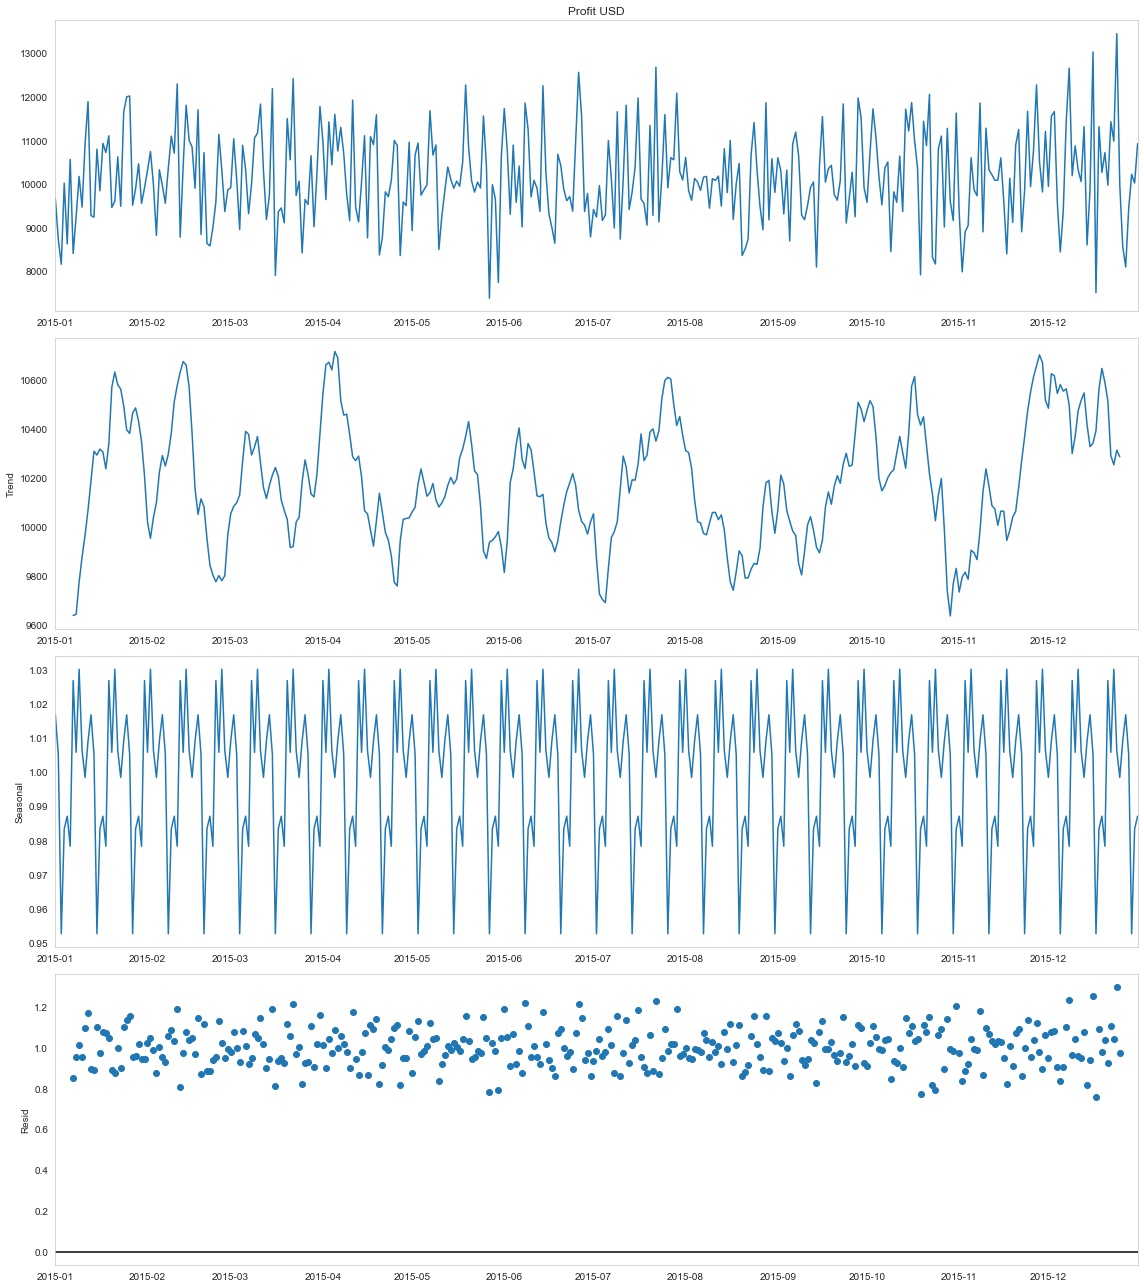

In [19]:
result1 = seasonal_decompose(ODpro_date_index['Profit USD'], model='multiplicative', period = 12)
fig = plt.figure()  
fig = result1.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Additive

<Figure size 432x288 with 0 Axes>

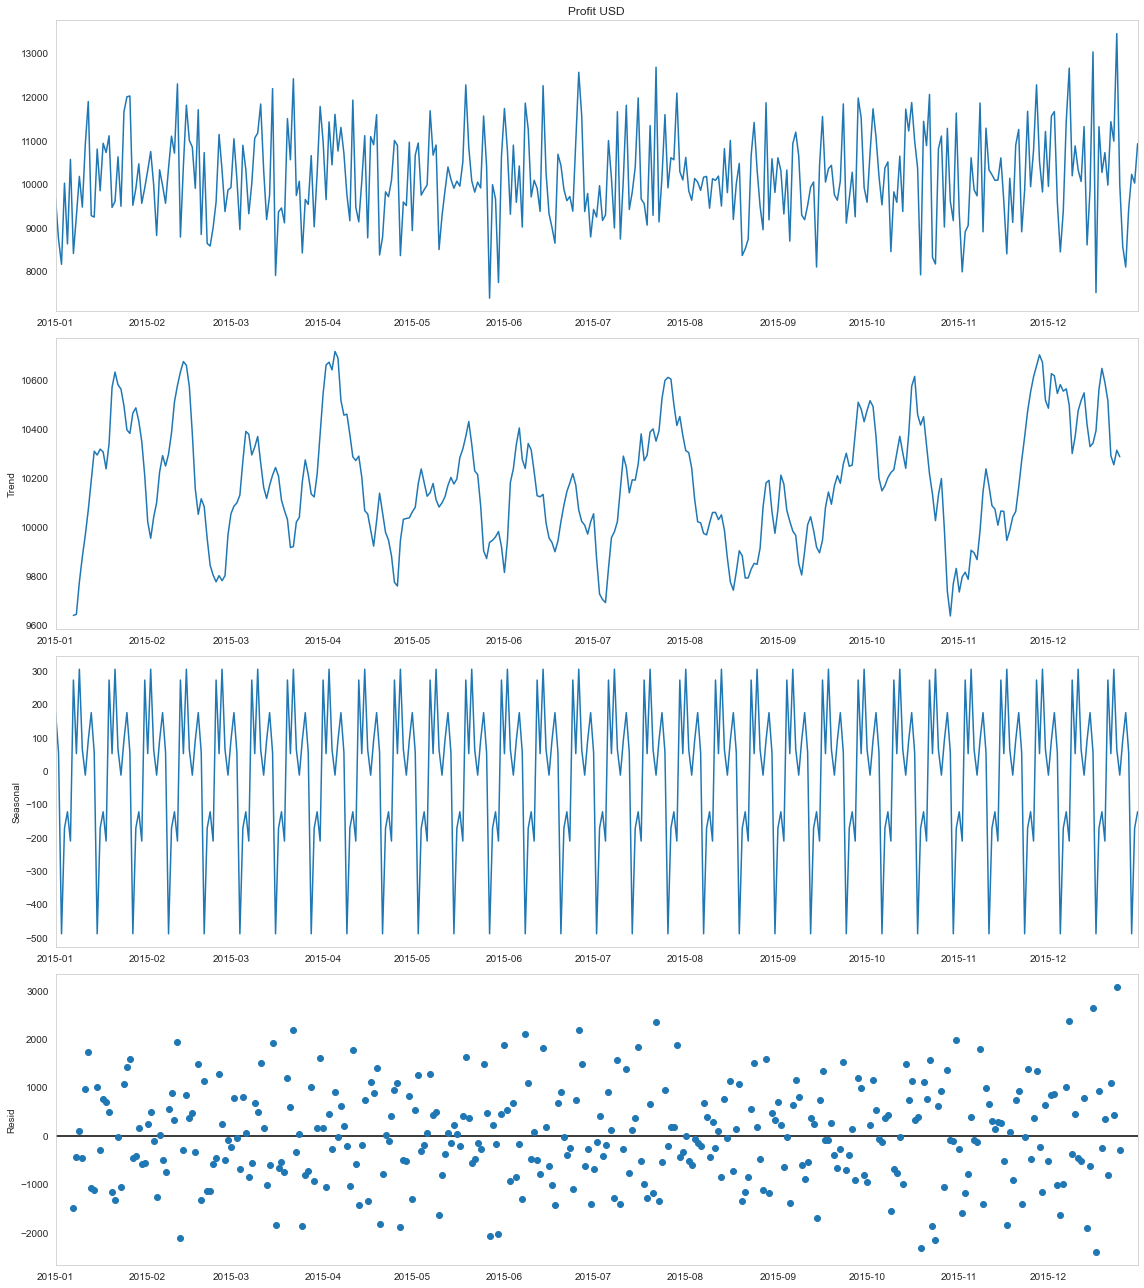

In [20]:
result2 = seasonal_decompose(ODpro_date_index['Profit USD'], model='additive', period = 12)
fig = plt.figure()  
fig = result2.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Sales

### Multiplicative

<Figure size 432x288 with 0 Axes>

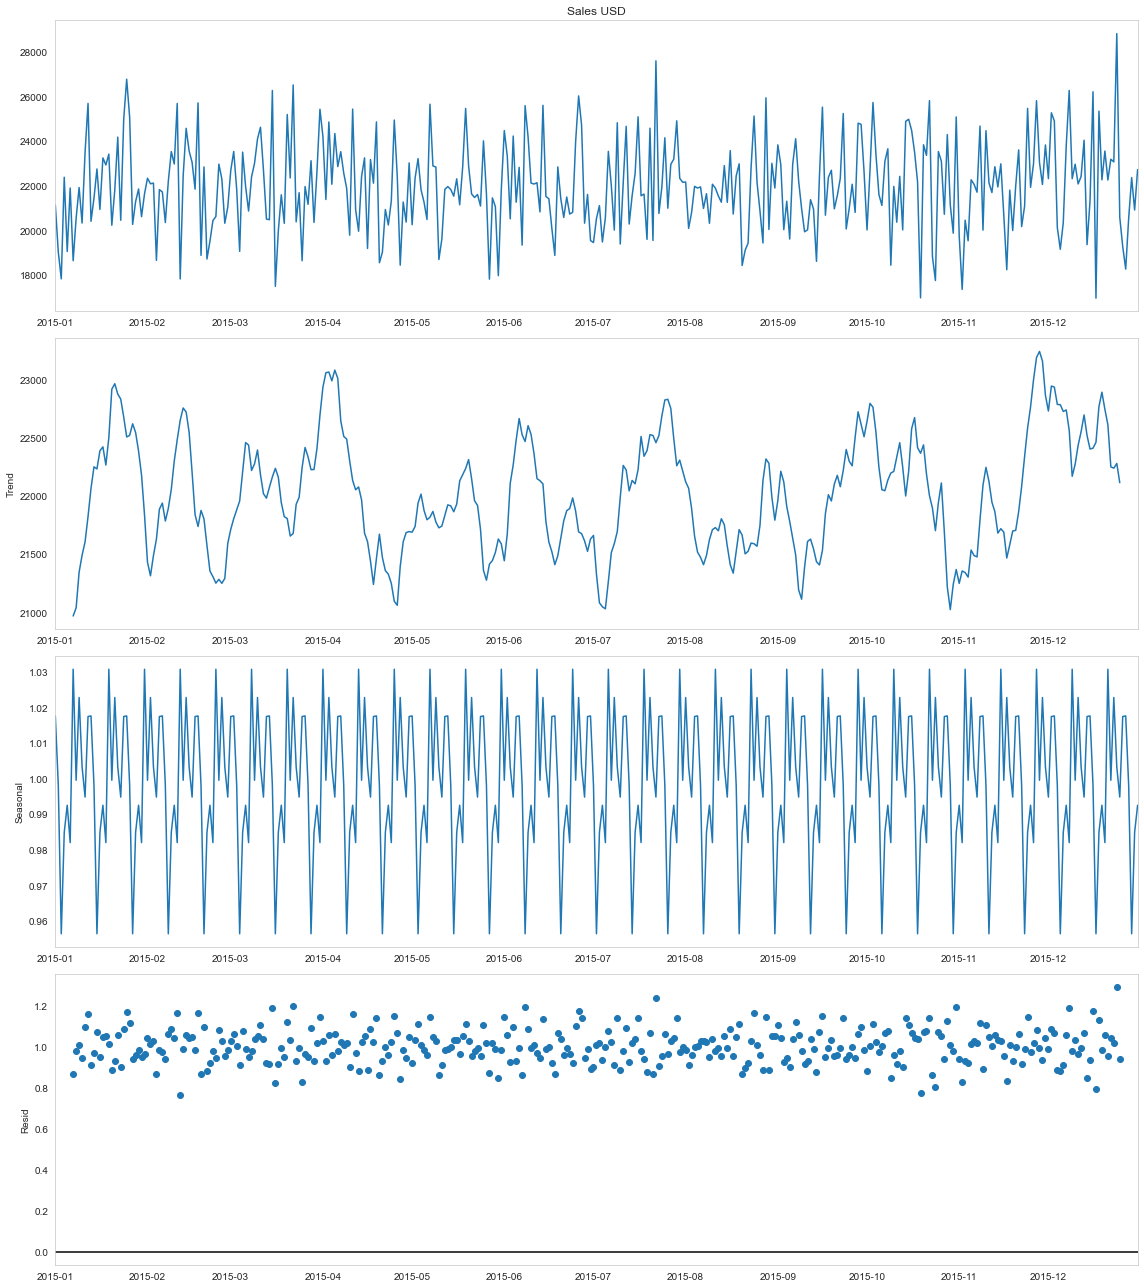

In [22]:
result3 = seasonal_decompose(ODsale_date_index['Sales USD'], model='multiplicative', period = 12)
fig = plt.figure()  
fig = result3.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Additive

<Figure size 432x288 with 0 Axes>

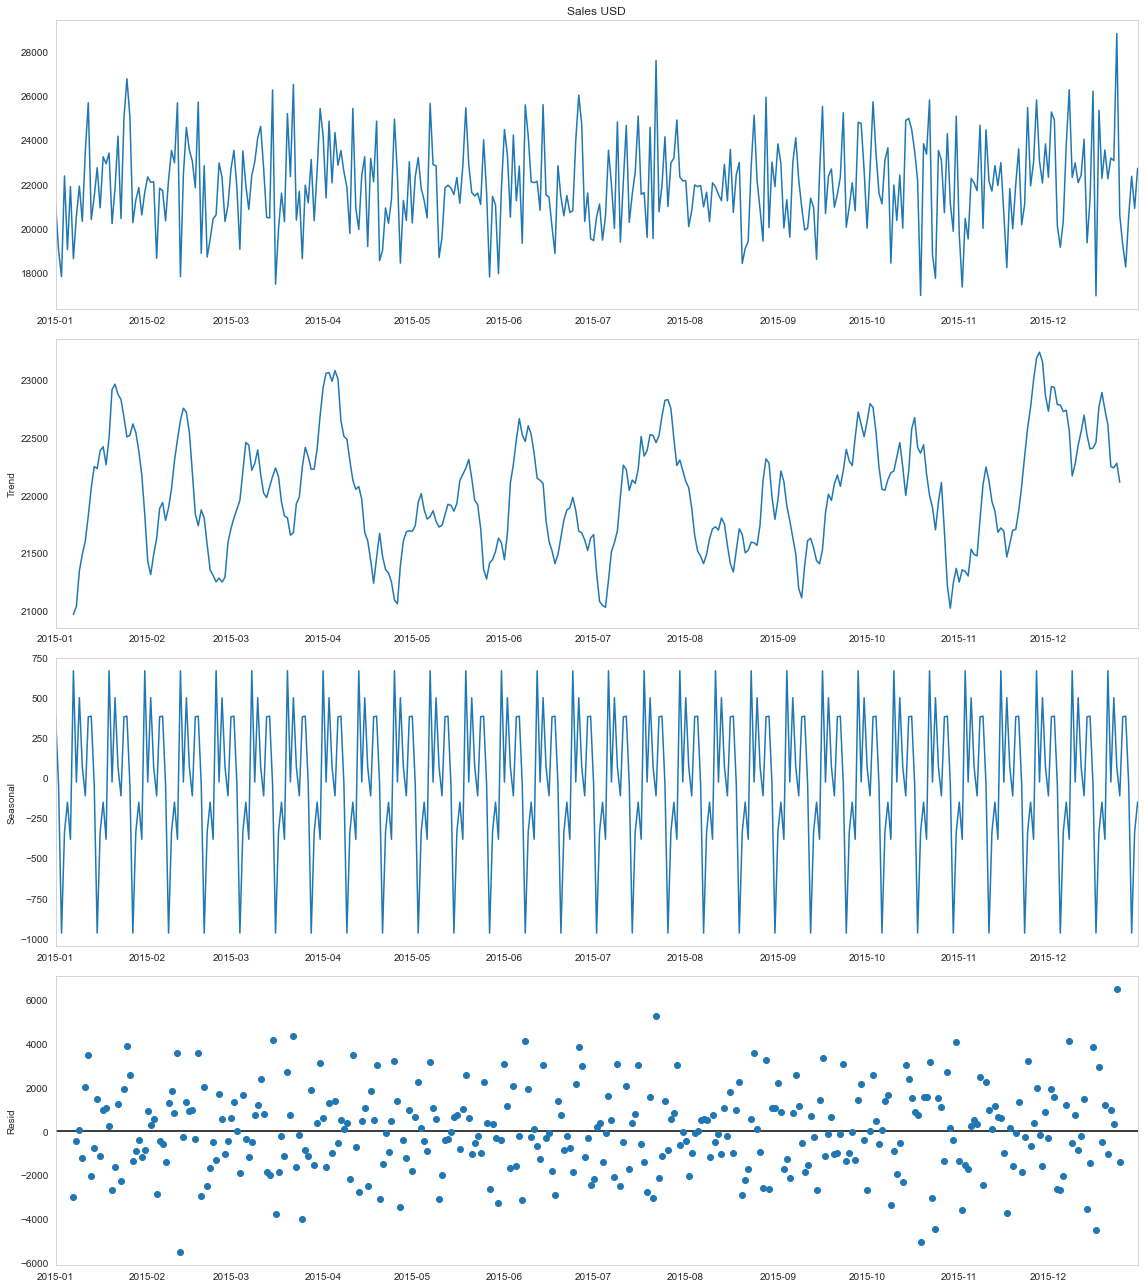

In [23]:
result4 = seasonal_decompose(ODsale_date_index['Sales USD'], model='additive', period = 12)
fig = plt.figure()  
fig = result4.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Preparing Dataset For Forecasting Model

### Profit 

No handles with labels found to put in legend.


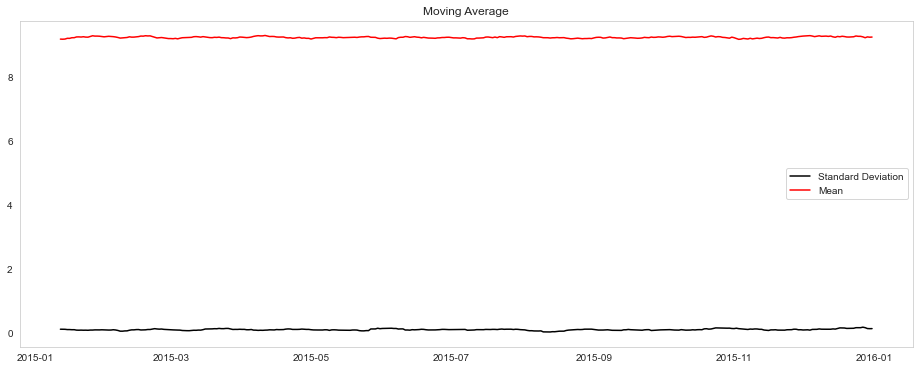

In [25]:
from pylab import rcParams
ODpro_log = np.log(ODpro_date_index['Profit USD'])
moving_avg = ODpro_log.rolling(12).mean()
std_dev = ODpro_log.rolling(12).std()

plt.figure(figsize=(16,6))
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

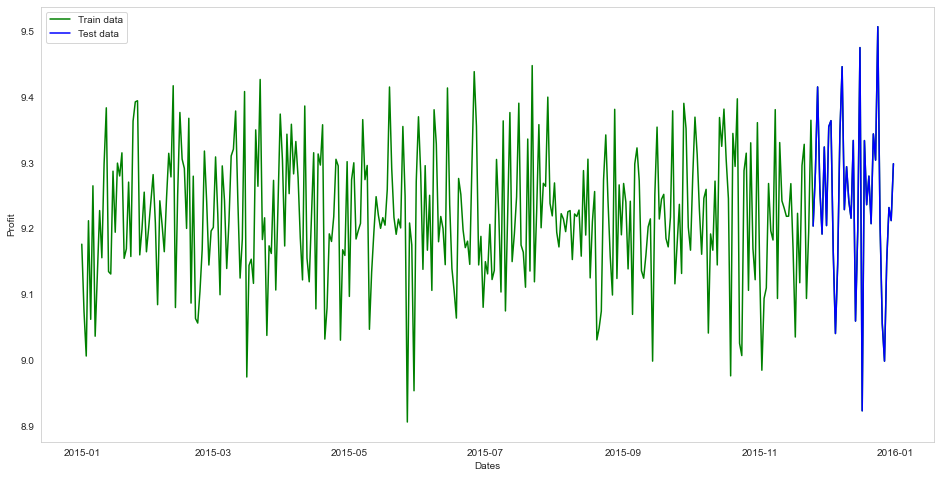

In [26]:
# Split data into Train and Training set
train_data1, test_data1 = ODpro_log[5:int(len(ODpro_log)*0.9)], ODpro_log[int(len(ODpro_log)*0.9):]
plt.figure(figsize=(16,8))
###plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Profit')
plt.plot(ODpro_log, 'green', label='Train data')
plt.plot(test_data1, 'blue', label='Test data')
plt.legend()

### Sales

No handles with labels found to put in legend.


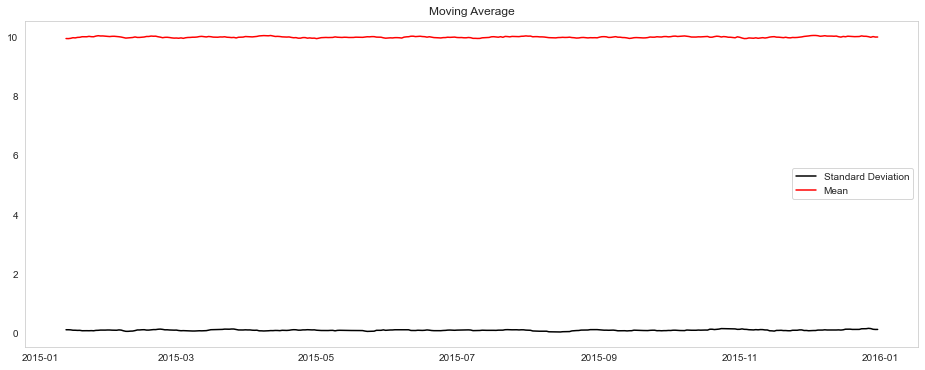

In [28]:
from pylab import rcParams
ODsale_log = np.log(ODsale_date_index['Sales USD'])
moving_avg2 = ODsale_log.rolling(12).mean()
std_dev2 = ODsale_log.rolling(12).std()

plt.figure(figsize=(16,6))
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev2, color ="black", label = "Standard Deviation")
plt.plot(moving_avg2, color="red", label = "Mean")
plt.legend()
plt.show()

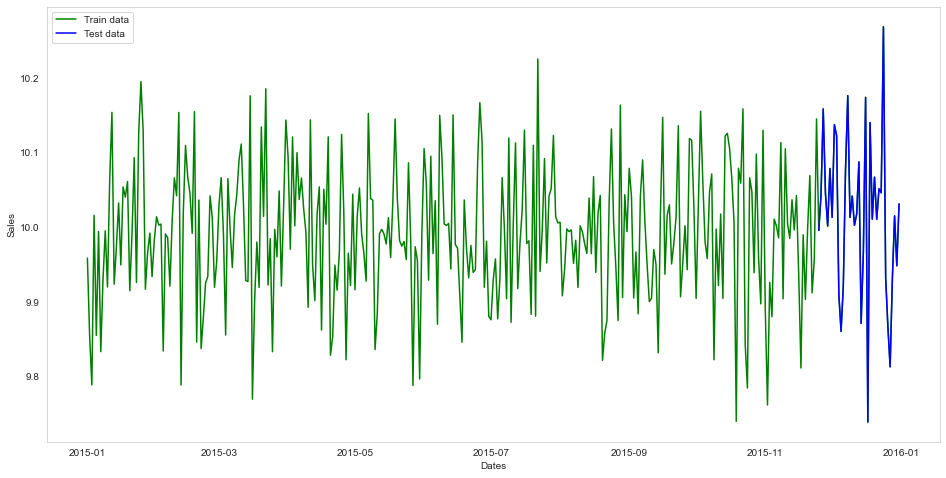

In [29]:
# Split data into Train and Training set
train_data2, test_data2 = ODsale_log[5:int(len(ODsale_log)*0.9)], ODsale_log[int(len(ODsale_log)*0.9):]
plt.figure(figsize=(16,8))
###plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Sales')
plt.plot(ODsale_log, 'green', label='Train data')
plt.plot(test_data2, 'blue', label='Test data')
plt.legend()

### AUTO ARIMA Model

### Profit

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.39 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-349.386, Time=0.19 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-440.776, Time=0.85 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.67 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-351.309, Time=0.14 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-347.958, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-477.010, Time=3.16 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.75 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.50 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-478.960, Time=2.51 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-442.410, Time=0.65 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.22 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.67 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-477.017, Time=2.21 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-475.8

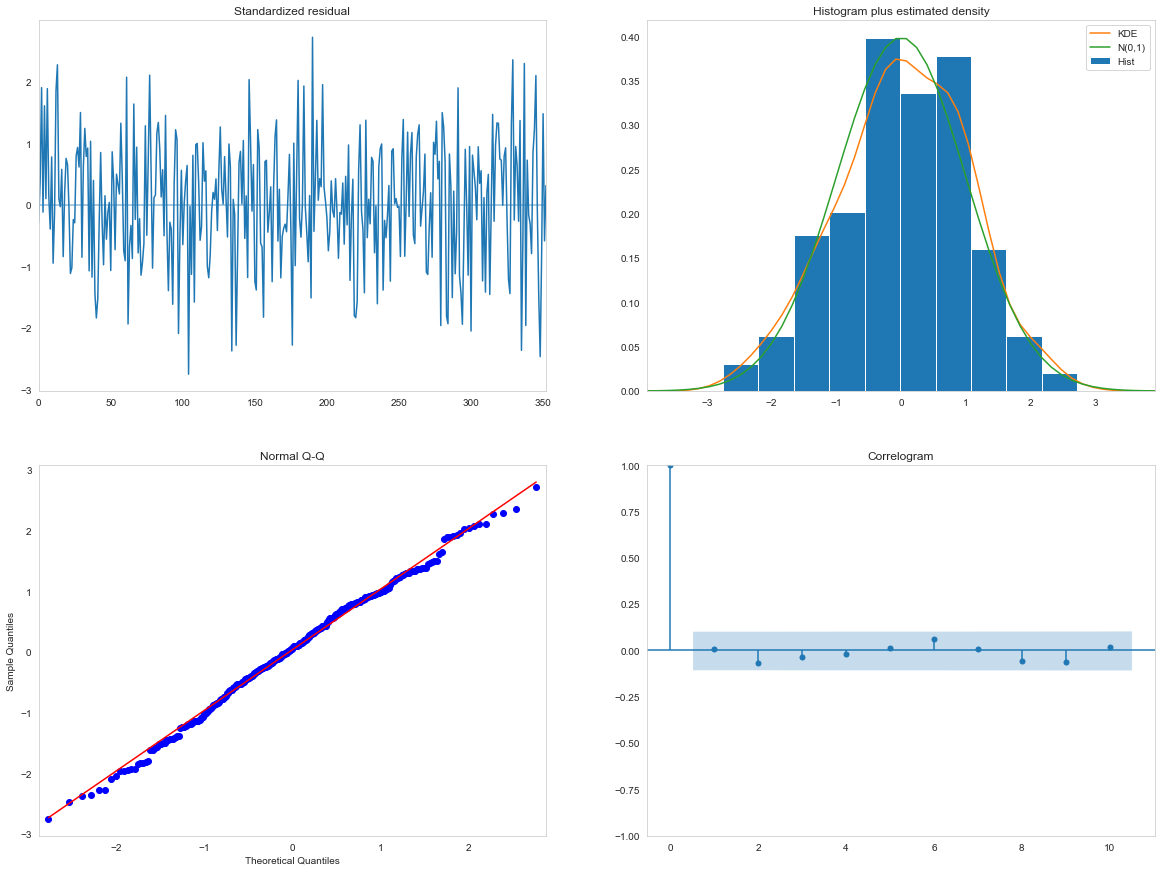

In [30]:
smodel1 = pm.auto_arima(ODpro_log, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


print(smodel1.summary())
smodel1.plot_diagnostics(figsize=(20,15))
plt.show()

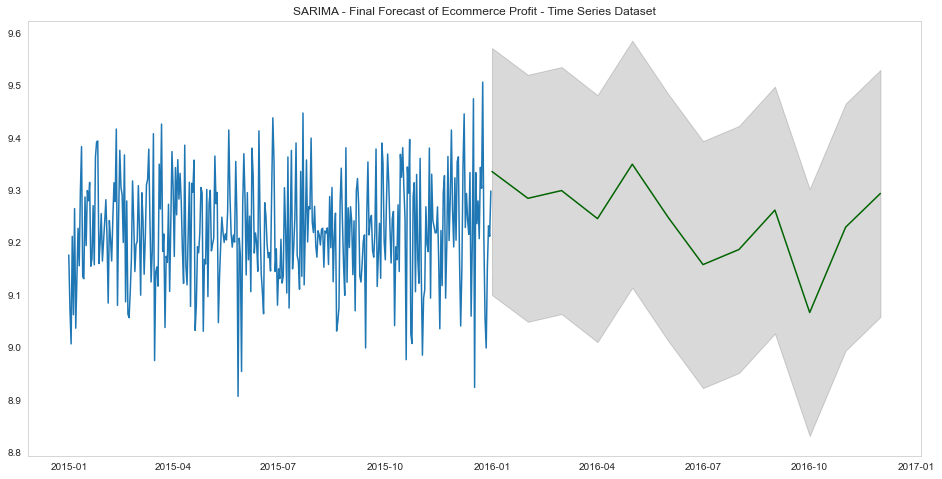

In [36]:
# Forecast
n_periods = 12
fitted, confint = smodel1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(ODpro_log.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16,8))
plt.plot(ODpro_log)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Ecommerce Profit - Time Series Dataset")
plt.show()

### Sale

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-425.985, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-528.365, Time=1.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-427.923, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-424.372, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-564.533, Time=3.09 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-566.509, Time=2.44 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-529.937, Time=1.01 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-564.533, Time=2.17 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-562.5

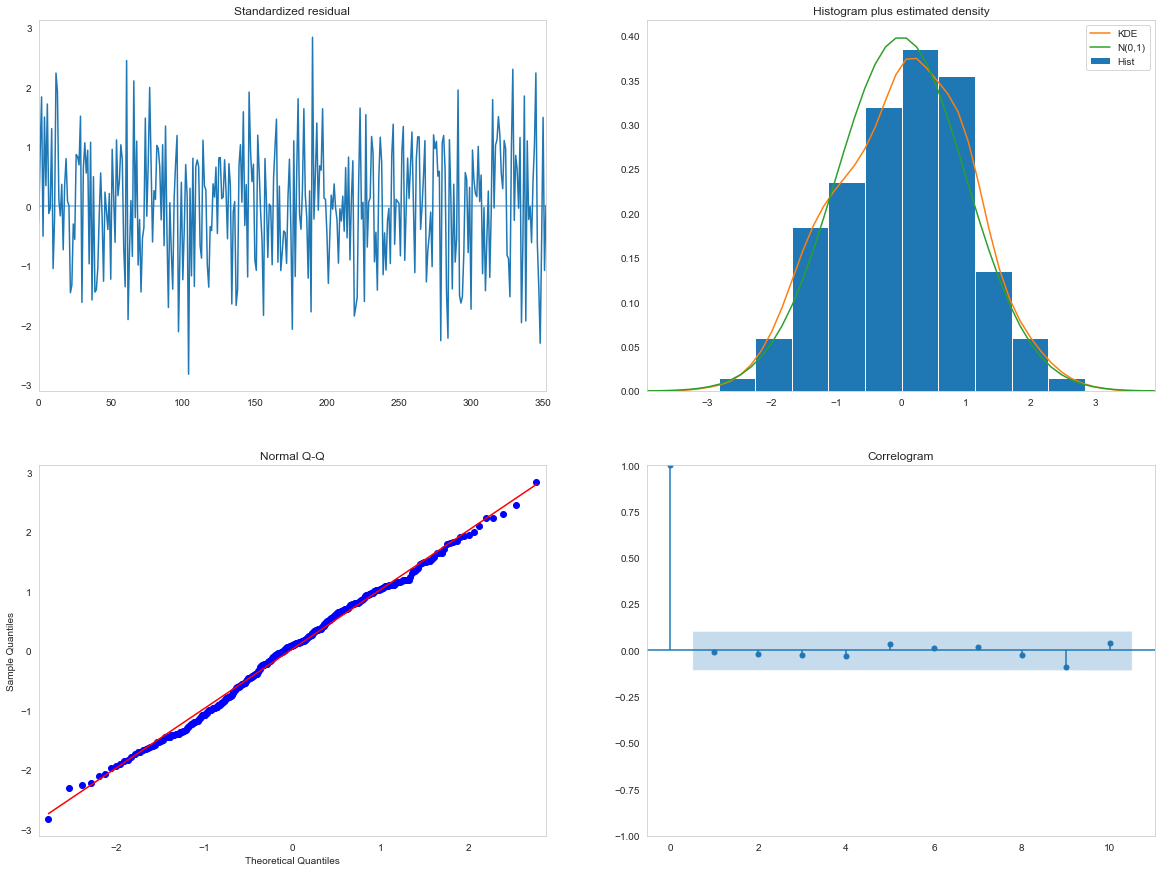

In [34]:
smodel2 = pm.auto_arima(ODsale_log, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


print(smodel2.summary())
smodel2.plot_diagnostics(figsize=(20,15))
plt.show()

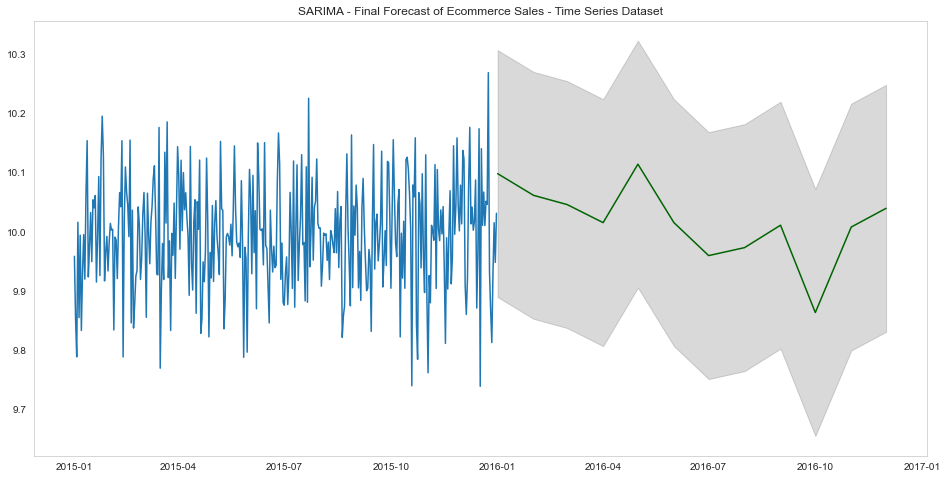

In [35]:
# Forecast
n_periods = 12
fitted2, confint = smodel2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc2 = pd.date_range(ODsale_log.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series2 = pd.Series(fitted2, index=index_of_fc2)
lower_series2 = pd.Series(confint[:, 0], index=index_of_fc2)
upper_series2 = pd.Series(confint[:, 1], index=index_of_fc2)

# Plot
plt.figure(figsize=(16,8))
plt.plot(ODsale_log)
plt.plot(fitted_series2, color='darkgreen')
plt.fill_between(lower_series2.index, 
                 lower_series2, 
                 upper_series2, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Ecommerce Sales - Time Series Dataset")
plt.show()

### FBProphet Model

### Selecting and Renaming Dataset To Fit FBProphet Model

In [38]:
# Profit
ODpro_p = ODpro[['Order Date','Profit USD']]
ODpro_p.columns=['ds','y']

# Sale
ODsale_p = ODsale[['Order Date','Sales USD']]
ODsale_p.columns=['ds','y']

# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet = Prophet(interval_width=0.95)

### Fitting FBProphet Model To Profit Dataset

In [39]:
prophet.fit(ODpro_p)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Making Future Profit Data For Forecasting

In [40]:
future_ODpro_dates = prophet.make_future_dataframe(periods=12, freq='MS')
future_ODpro_dates.tail()

,ds
372,2016-08-01
373,2016-09-01
374,2016-10-01
375,2016-11-01
376,2016-12-01


### FBProphet Forecasting Profit Data

In [41]:
forecast = prophet.predict(future_ODpro_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-01,10013.650012,7918.460537,11963.786276
1,2015-01-02,10015.211574,7859.307143,12018.962805
2,2015-01-03,10020.910079,7985.255716,11938.913974
3,2015-01-04,10206.854243,8120.697176,12168.703870
4,2015-01-05,10046.127239,8116.239605,12024.016202


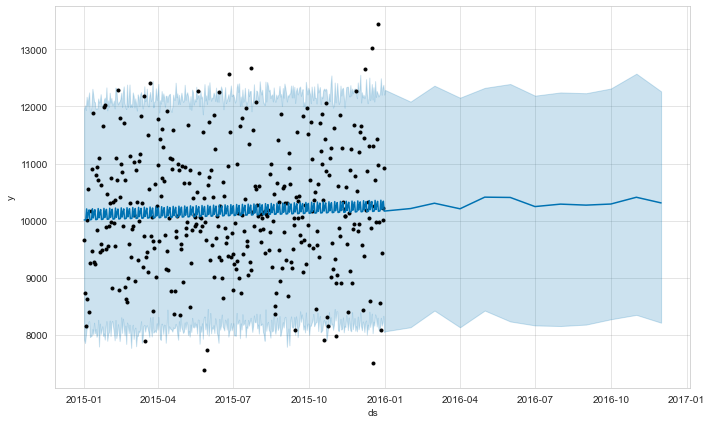

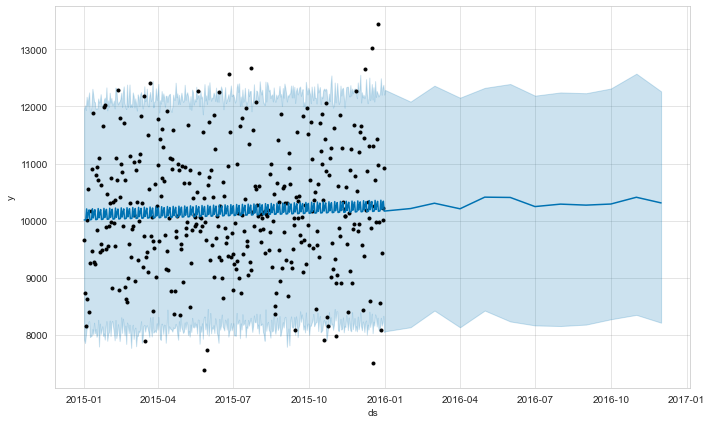

In [42]:
prophet.plot(forecast, uncertainty=True)

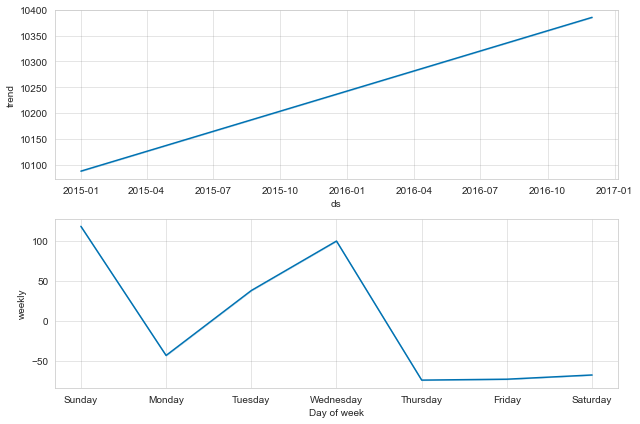

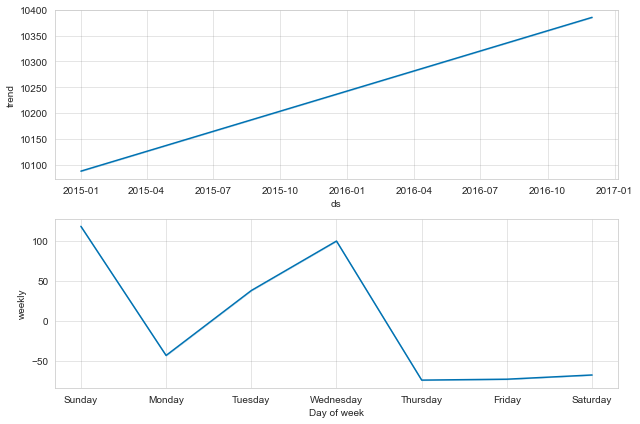

In [43]:
prophet.plot_components(forecast)

### Fitting FBProphet Model To Sales Dataset

In [ ]:
prophet.fit(ODsale_p)

### Making Future Sale Data For Forecasting

In [ ]:
future_ODsale_dates = prophet.make_future_dataframe(periods=12, freq='MS')
future_ODsale_dates.tail()

### FBProphet Forecasting Sales Data

In [ ]:
forecast = prophet.predict(future_ODsale_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

In [ ]:
prophet.plot(forecast, uncertainty=True)

In [ ]:
prophet.plot_components(forecast)